# Solutions
Simulation results will be different unless you use the seed. Check that your strategy for completing the exercises is similar to the sample solutions here, in that case.

## Exercise 1
Simulate December 2019 using the seed of 27.

In [1]:
!python ../../ch_08/simulate.py \
    -s 27 \
    -u ../../ch_08/user_data/user_base.txt \
    -i ../../ch_08/user_data/user_ips.json \
    -l dec_2019_log.csv \
    -hl dec_2019_attacks.csv \
    31 "2019-12-01"

[INFO] [ simulate.py ] Simulating 31.0 days...
[INFO] [ simulate.py ] Saving logs
[INFO] [ simulate.py ] All done!


## Imports for Remaining Exercises

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Exercise 2
Find the number of unique usernames, attempts, successes, failures, and success/failure rates per IP address.

In [3]:
dec_log = pd.read_csv('dec_2019_log.csv', parse_dates=True, index_col='datetime')

log_aggs = dec_log.assign(
    failures=lambda x: np.invert(x.success)
).groupby('source_ip').agg(
    {'username': 'nunique', 'success':'sum', 'failures': 'sum'}
).assign(
    attempts=lambda x: x.success + x.failures,
    success_rate=lambda x: x.success / x.attempts,
    failure_rate=lambda x: 1 - x.success_rate
).dropna().reset_index()

log_aggs.head()

,source_ip,username,success,failures,attempts,success_rate,failure_rate
0,1.138.149.116,1,24,9,33,0.727273,0.272727
1,100.43.18.36,1,7,2,9,0.777778,0.222222
2,101.113.31.197,1,23,2,25,0.920000,0.080000
3,101.154.143.93,1,6,0,6,1.000000,0.000000
4,101.168.177.211,135,43,198,241,0.178423,0.821577


## Exercise 3
Create two subplots with failures versus attempts on the left and failure rate versus distinct usernames on the right. Draw a decision boundary for what you see. Be sure to color by whether or not it is a hacker IP address.

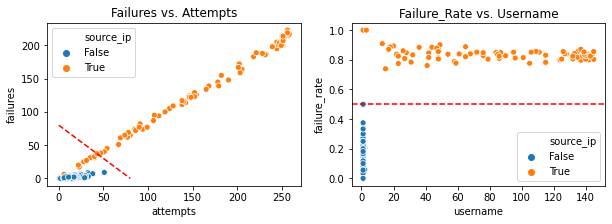

In [4]:
is_attack_ip = log_aggs.source_ip.isin(
    pd.read_csv('dec_2019_attacks.csv').source_ip
)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

for ax, (x, y) in zip(axes, (
    ('attempts', 'failures'), ('username', 'failure_rate')
)):
    ax = sns.scatterplot(
        x=log_aggs[x], 
        y=log_aggs[y], 
        hue=is_attack_ip,
        ax=ax
    )
    ax.set_title(f'{y.title()} vs. {x.title()}')

# boundaries
axes[0].plot([0, 80], [80, 0], 'r--')
axes[1].axhline(0.5, color='red', linestyle='--')

## Exercise 4
Build a rule-based criteria using percent difference from the median that flags an IP address if failures and attempts are 5 times the median OR if distinct usernames is 5 times the median.

In [5]:
hourly_ip_logs = dec_log.assign(
    failures=lambda x: np.invert(x.success)
).groupby('source_ip').resample('1H').agg(
    {'username': 'nunique', 'success':'sum', 'failures': 'sum'}
).assign(
    attempts=lambda x: x.success + x.failures,
    success_rate=lambda x: x.success / x.attempts,
    failure_rate=lambda x: 1 - x.success_rate
).dropna().reset_index()

hourly_ip_logs.head()

,source_ip,datetime,username,success,failures,attempts,success_rate,failure_rate
0,1.138.149.116,2019-12-03 07:00:00,1,4,2,6,0.666667,0.333333
1,1.138.149.116,2019-12-20 03:00:00,1,2,2,4,0.500000,0.500000
2,1.138.149.116,2019-12-20 22:00:00,1,2,1,3,0.666667,0.333333
3,1.138.149.116,2019-12-25 06:00:00,1,4,2,6,0.666667,0.333333
4,1.138.149.116,2019-12-25 07:00:00,1,1,0,1,1.000000,0.000000


Function from chapter for getting baselines:

In [6]:
def get_baselines(hourly_ip_logs, func, *args, **kwargs):
    """
    Calculate hourly bootstrapped statistic per column.
    
    Parameters:
        - hourly_ip_logs: Data to sample from.
        - func: Statistic to calculate.
        - args: Additional positional arguments for `func`
        - kwargs: Additional keyword arguments for `func`
    
    Returns:
        A pandas DataFrame of hourly bootstrapped statistics
    """
    if isinstance(func, str):
        func = getattr(pd.DataFrame, func)
    return hourly_ip_logs.assign(
        hour=lambda x: x.datetime.dt.hour
    ).groupby('hour').apply(
        lambda x: x.sample(10, random_state=0, replace=True).pipe(func, *args, **kwargs, numeric_only=True)
    )

Get baseline:

In [7]:
medians = get_baselines(hourly_ip_logs, 'median')

Flag if both failures and attempts are 5 times higher than the median or if usernames tried is 5 times higher than the median:

In [8]:
flagged_ips = hourly_ip_logs.assign(
    hour=lambda x: x.datetime.dt.hour
).join(
    medians, on='hour', rsuffix='_median'
).assign(
    flag_median=lambda x: np.logical_or(
        np.logical_and(
            x.failures_median * 5 <= x.failures,
            x.attempts_median * 5 <= x.attempts
        ), x.username_median * 5 <= x.username
    )
).query('flag_median').source_ip.drop_duplicates()

## Exercise 5
Calculate metrics to evaluate how well the ensemble method performed. We can use the `evaluate()` function from the chapter:

In [33]:
def evaluate(alerted_ips, attack_ips, log_ips):
    """
    Calculate true positives (TP), false positives (FP), 
    true negatives (TN), and false negatives (FN) for 
    IP addresses flagged as suspicious.
    
    Parameters:
        - alerted_ips: Pandas series of flagged IP addresses
        - attack_ips: Pandas series of attacker IP addresses
        - log_ips: Pandas series of all IP addresses seen
    
    Returns:
        Tuple of form (TP, FP, TN, FN)
    """
    tp = alerted_ips.isin(attack_ips).sum()
    tn = np.invert(np.isin(log_ips[~log_ips.isin(alerted_ips)].unique(), attack_ips)).sum()
    fp = np.invert(
        np.isin(log_ips[log_ips.isin(alerted_ips)].unique(), attack_ips)
    ).sum()
    fn = np.invert(
        np.isin(log_ips[log_ips.isin(attack_ips)].unique(), alerted_ips)
    ).sum()
    return tp, fp, tn, fn

Next we make a partial to store the attacker IP addreses and the unique IP addresses in the logs:

In [34]:
# make this easier to call
from functools import partial
scores = partial(
    evaluate, 
    attack_ips=pd.read_csv('dec_2019_attacks.csv').source_ip, 
    log_ips=dec_log.source_ip.drop_duplicates()
)

We can evaluate the performance with the `classification_stats()` function from the chapter:

In [35]:
def classification_stats(tp, fp, tn, fn):
    """Calculate accuracy, precision, recall, and F1-score"""
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    f1_score = 2 * precision * recall / (precision + recall)
    return {
        'accuracy' : (tp + tn) / (tp + fp + tn + fn),
        'precision' : precision,
        'recall' : recall,
        'F1-score' : f1_score
    }

Performance is pretty good:

In [36]:
classification_stats(*scores(flagged_ips))

{'accuracy': 0.9391304347826087,
 'precision': 0.8118811881188119,
 'recall': 0.9761904761904762,
 'F1-score': 0.8864864864864865}